In [40]:
import copy

In [41]:
import numpy as np

def huber(y):
    if np.abs(y) <= 1:
        return y**2 / 2
    else:
        return np.abs(y) - 1 / 2

def toy_problem(x):
    pi_values = [10**(-i) for i in range(1, 7)]
    Qi_values = []
    for i in range(1, 7):
        Qi_value = np.random.choice([0, 1], size=6, p=[1- pi_values[i-1], pi_values[i-1]])[0]
        Qi_values.append(Qi_value)
    result = 0
    for i in range(6):
        result += (1 - Qi_values[i]) * huber(x[i] - 1) + Qi_values[i] / np.sqrt(pi_values[i]) * huber(x[i] + 1)

    return result, Qi_values

# Example usage

np.random.seed(43)
x_example = np.random.randn(6)  # Replace with your input vector
y_example = 5
result_example, qi = toy_problem(x_example)
print(f"The result for x = {x_example} is: {result_example}")


The result for x = [ 0.25739993 -0.90848143 -0.37850311 -0.5349156   0.85807335 -0.41300998] is: 4.520709142916468


In [42]:
def derivative(x, Qi_values):
    pi_values = [10**(-i) for i in range(1, 7)]

    gradient = np.zeros_like(x)

    for i in range(6):
        factor = 1 / np.sqrt(pi_values[i])
        if np.abs(x[i] - 1) <= 1:
            grad_huber_minus = x[i] - 1
        else:
            grad_huber_minus = np.sign(x[i] - 1)

        if np.abs(x[i] + 1) <= 1:
            grad_huber_plus = x[i] + 1
        else:
            grad_huber_plus = np.sign(x[i] + 1)

        gradient[i] = (1 - Qi_values[i]) * grad_huber_minus + Qi_values[i] * factor * grad_huber_plus
    return gradient
print(derivative(x_example, qi))

[-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]


In [93]:
def adam(x, objective, derivative, alpha, beta1, beta2, eps=1e-8, n_iter=100):
    m = [0.0 for _ in range(6)]
    v = [0.0 for _ in range(6)]
    gradients = []
    score, qi = objective(x)
    for t in range(n_iter):
        gradient = derivative(x,qi)
        g = gradient
        for i in range(6):
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
            #mhat = m[i] / (1.0 - np.power(beta1, t+1))
            #vhat = v[i] / (1.0 - np.power(beta2, t+1))
            mhat = m[i] / (1.0 - beta1 ** (t+1))
            vhat = v[i] / (1.0 - beta2 ** (t+1))
            x[i] = x[i] - alpha * mhat / (np.sqrt(vhat) + eps)
        score = objective(x)[0]
        gradients.append(g)
        #print((t, x, score, g))
        if t % 10000 == 0:
            print(t, x, score, g)
    return x, score, gradients

In [44]:
np.random.seed(43)
x = copy.deepcopy(x_example) 
y_example = 5
_, _, gs = adam(x, toy_problem, derivative, 0.02, 0.8, 0.999, n_iter=10**3)

0 [ 0.27739993 -0.88848143 -0.35850311 -0.5149156   0.87807334 -0.39300998] 6.620697591453096 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]


In [75]:
def expected_gradient_norm_squared(gradients, num_samples=1000): # Generate random samples
    squared_norms = np.zeros(len(gradients))

    for i in range(len(gradients)):
        gradient = gradients[i]
        squared_norms[i] = np.sum(gradient**2)

    expected_value = np.mean(squared_norms)
    return expected_value

ev = expected_gradient_norm_squared(gs)
print(ev)

3.1775489745102585


In [58]:
x = copy.deepcopy(x_example)
alphas = []
for alpha in [10**-i for i in range(4, 2, -1)]:
    _, _, gs = adam(x, toy_problem, derivative, alpha, 0, 1 - 10**-6, n_iter=10**3)
    alphas.append(expected_gradient_norm_squared(gs))
print(alphas)

(0, array([ 0.25749993, -0.90838143, -0.37840311, -0.5348156 ,  0.85817335,
       -0.41290998]), 4.520220700249608, array([-0.74260007, -1.        , -1.        , -1.        , -0.14192665,
       -1.        ]))
0 [ 0.25749993 -0.90838143 -0.37840311 -0.5348156   0.85817335 -0.41290998] 4.520220700249608 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
(1, array([ 0.25759992, -0.90828143, -0.37830311, -0.5347156 ,  0.85827331,
       -0.41280998]), 4.519732287577492, array([-0.74250007, -1.        , -1.        , -1.        , -0.14182665,
       -1.        ]))
(2, array([ 0.25769991, -0.90818143, -0.37820311, -0.5346156 ,  0.85837324,
       -0.41270998]), 4.519243904889628, array([-0.74240008, -1.        , -1.        , -1.        , -0.14172669,
       -1.        ]))
(3, array([ 0.25779988, -0.90808143, -0.37810311, -0.5345156 ,  0.85847313,
       -0.41260998]), 4.518755552175502, array([-0.74230009, -1.        , -1.        , -1.        , -0.14162676,
       -1.

In [47]:
x = copy.deepcopy(x_example)
b1 = []
for beta1 in [0., 0.5, 0.8, 0.9, 0.99]:
    _, _, gs = adam(x, toy_problem, derivative, 10**-5, beta1, 1 - 10**-6, n_iter=10**3)
    b1.append(expected_gradient_norm_squared(gs))

0 [ 0.25740993 -0.90847143 -0.37849311 -0.5349056   0.85808335 -0.41299998] 4.520660297749782 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.26737622 -0.89847143 -0.36849311 -0.5249056   0.86790535 -0.40299998] 4.471963418858806 [-0.73263378 -1.         -1.         -1.         -0.13210465 -1.        ]
0 [ 0.27734219 -0.88847143 -0.35849311 -0.5149056   0.8777147  -0.39299998] 4.42346412026825 [-0.72266781 -1.         -1.         -1.         -0.1222953  -1.        ]
0 [ 0.28730811 -0.87847143 -0.34849311 -0.5049056   0.88751093 -0.38299998] 4.3751618840690405 [-0.71270189 -1.         -1.         -1.         -0.11249907 -1.        ]
0 [ 0.29727422 -0.86847143 -0.33849311 -0.4949056   0.89729341 -0.37299998] 6.601346909528681 [-0.70273578 -1.         -1.         -1.         -0.10271659 -1.        ]


In [48]:
x = copy.deepcopy(x_example)
b2 = []
for beta2 in [0.9, 0.99, 0.999, 0.9999]:
    _, _, gs = adam(x, toy_problem, derivative, 10**-6, 0, beta2, n_iter=10**3)
    b2.append(expected_gradient_norm_squared(gs))

0 [ 0.25740093 -0.90848043 -0.37850211 -0.5349146   0.85807435 -0.41300898] 4.5207042583908 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25840091 -0.90748043 -0.37750211 -0.5339146   0.85907428 -0.41200898] 4.515820751397454 [-0.74160009 -1.         -1.         -1.         -0.14092672 -1.        ]
0 [ 0.2594008  -0.90648043 -0.37650211 -0.5329146   0.86007369 -0.41100898] 4.510939391796244 [-0.7406002  -1.         -1.         -1.         -0.13992731 -1.        ]
0 [ 0.2604005  -0.90548043 -0.37550211 -0.5319146   0.8610721  -0.41000898] 4.506060309267419 [-0.7396005 -1.        -1.        -1.        -0.1389289 -1.       ]


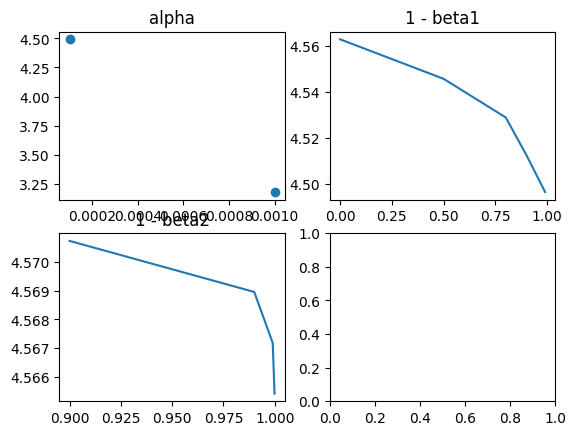

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

figure, axis = plt.subplots(2, 2)
axis[0,0].scatter([10**-4,10**-3], alphas)
# For Sine Function 
#axis[0, 0].plot([10**-4,10**-3], alphas) 
axis[0, 0].set_title("alpha") 
  
# For Cosine Function 
axis[0, 1].plot([0., 0.5, 0.8, 0.9, 0.99], b1) 
axis[0, 1].set_title("1 - beta1") 
  
# For Tangent Function 
axis[1, 0].plot([0.9, 0.99, 0.999, 0.9999], b2) 
axis[1, 0].set_title("1 - beta2") 
  
plt.show()

0 [ 0.25740093 -0.90848043 -0.37850211 -0.5349146   0.85807435 -0.41300898] 4.5207042583908 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740309 -0.90847827 -0.37849994 -0.53491244  0.85807651 -0.41300682] 4.5206936966969025 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740993 -0.90847143 -0.37849311 -0.5349056   0.85808335 -0.41299998] 4.520660297749782 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.2573683  -0.90844981 -0.37847148 -0.53488398  0.85810497 -0.41297836] 4.520601647772962 [ 3.16227766 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25749993 -0.90838143 -0.37840311 -0.5348156   0.85817335 -0.41290998] 4.520220700249608 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25771615 -0.90816521 -0.37818688 -0.53459937  0.85838957 -0.41269375] 4.519164619960004 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.   

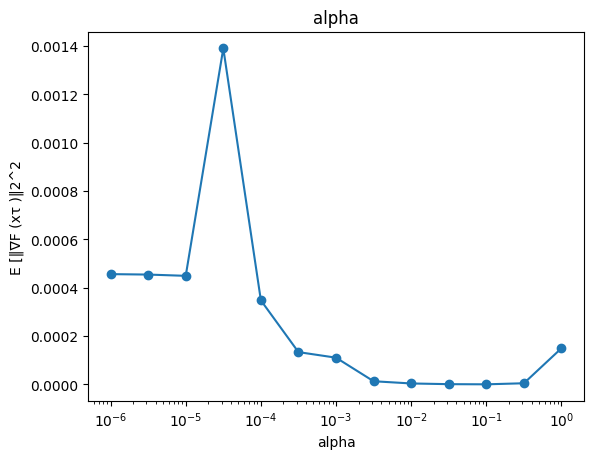

0 [ 0.25740993 -0.90847143 -0.37849311 -0.5349056   0.85808335 -0.41299998] 4.520660297749782 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740993 -0.90847143 -0.37849311 -0.5349056   0.85808335 -0.41299998] 4.520660297749782 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740993 -0.90847143 -0.37849311 -0.5349056   0.85808335 -0.41299998] 4.520660297749782 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740993 -0.90847143 -0.37849311 -0.5349056   0.85808335 -0.41299998] 4.520660297749782 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740993 -0.90847143 -0.37849311 -0.5349056   0.85808335 -0.41299998] 6.640080774768292 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740993 -0.90847143 -0.37849311 -0.5349056   0.85808335 -0.41299998] 4.520660297749782 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.  

/tmp/ipykernel_129969/2974602043.py:14: RuntimeWarning: invalid value encountered in scalar divide
  mhat = m[i] / (1.0 - beta1 ** (t+1))


0 [nan nan nan nan nan nan] nan [-0.74260007 -1.         19.65345744 -1.         -0.14192665 -1.        ]


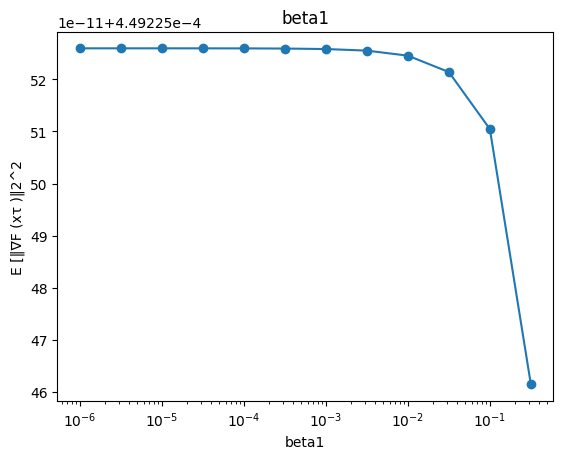

0 [ 0.25740093 -0.90848043 -0.37850211 -0.5349146   0.85807435 -0.41300898] 4.5207042583908 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740093 -0.90848043 -0.37850211 -0.5349146   0.85807435 -0.41300898] 4.5207042583908 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740093 -0.90848043 -0.37850211 -0.5349146   0.85807435 -0.41300898] 4.5207042583908 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740093 -0.90848043 -0.37850211 -0.5349146   0.85807435 -0.41300898] 4.5207042583908 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740093 -0.90848043 -0.37850211 -0.5349146   0.85807435 -0.41300898] 6.64008959155967 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [ 0.25740093 -0.90848043 -0.37850211 -0.5349146   0.85807435 -0.41300898] 4.5207042583908 [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]
0 [

/tmp/ipykernel_129969/2974602043.py:15: RuntimeWarning: invalid value encountered in scalar divide
  vhat = v[i] / (1.0 - beta2 ** (t+1))


0 [nan nan nan nan nan nan] nan [-0.74260007 -1.         -1.         -1.         -0.14192665 -1.        ]


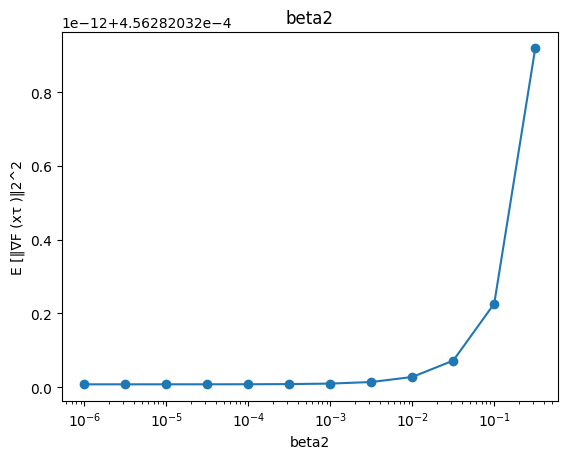

In [94]:
def plot_variation(parameter_values, param_name, n_iter=10**3, batch_size=1):
    results = []
    for param_value in parameter_values:
        x_t = copy.deepcopy(x_example)
        if param_name == 'alpha':
            alpha = param_value
            beta1 = 0
            beta2 = 1 - 10**-6
        elif param_name == 'beta1':
            alpha = 10**-5
            beta1 = param_value
            beta2 = 1 - 10**-6
        elif param_name == 'beta2':
            alpha = 10**-6
            beta1 = 0
            beta2 = param_value

        squared_norm = 0
        #for _ in range(n_iter):
            #x_t = np.random.randn(6)
        _, _, gradient = adam(x_t, toy_problem, derivative, alpha, beta1, beta2, n_iter=n_iter)
        expected_squared_norm = expected_gradient_norm_squared(gradient,n_iter)

        expected_squared_norm = expected_squared_norm / n_iter
        results.append(expected_squared_norm)

    plt.plot(parameter_values, results, marker='o')
    plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('E [‖∇F (xτ )‖2^2')
    plt.title(param_name)
    plt.show()
    
n=10**4
# Vary alpha in log scale between 10^(-6) and 1
alpha_values = np.logspace(-6, 0, 13)
plot_variation(alpha_values, 'alpha', n_iter=n)

# Vary 1 - beta1 in log scale between 10^(-6) and 1
beta1_values = np.logspace(-6, 0, 13)
plot_variation(beta1_values, 'beta1', n_iter=n)

# Vary 1 - beta2 in log scale between 10^(-6) and 1
beta2_values = np.logspace(-6, 0, 13)
plot_variation(beta2_values, 'beta2', n_iter=n)


In [121]:
import os
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor

In [96]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
train_ds = ImageFolder('./data/cifar10/train', transform=ToTensor())
test_ds = ImageFolder('./data/cifar10/test', transform=ToTensor())

batch_size = 128

train_loader =DataLoader(train_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size*2, shuffle=True)

100%|██████████| 135107811/135107811 [02:05<00:00, 1072764.73it/s]


In [97]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [98]:
def ConvLayer(inp, out, ks=3, s=1, p=1):
    return nn.Conv2d(inp, out, kernel_size=ks, stride=s, padding=p)

class CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.neural_net = nn.Sequential(
            ConvLayer(3, 32), nn.ReLU(),
            ConvLayer(32, 64), nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            ConvLayer(64, 128), nn.ReLU(),
            ConvLayer(128, 256), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ConvLayer(256, 512), nn.ReLU(),
            ConvLayer(512, 1024), nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Flatten(),
            nn.Linear(1024*4*4, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        return self.neural_net(x)

In [99]:
model = CIFAR10().to(device)

In [100]:
def accuracy_score(out, labels):
    _, preds = torch.max(out, dim=1)
    correct_preds = torch.sum(preds==labels).item()
    total_preds = len(preds)
    accuracy = torch.tensor(correct_preds/total_preds)
    return accuracy

In [118]:
import numpy as np

class AdamOptimizer:
    def __init__(self, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def initialize(self, parameters):
        self.m = [np.zeros_like(param.detach().numpy()) for param in parameters]
        self.v = [np.zeros_like(param.detach().numpy()) for param in parameters]
        print(len(self.m[0]))

    def update(self, gradients, parameters):
        if self.m is None:
            self.initialize(parameters)

        self.t += 1
        lr_t = self.alpha * np.sqrt(1 - self.beta2**self.t) / (1 - self.beta1**self.t)
        
        print(len(parameters))
        for i in range(len(parameters)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradients[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (gradients[i] ** 2)

            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            parameters[i] -= lr_t * m_hat / (np.sqrt(v_hat) + self.epsilon)


# Create an instance of AdamOptimizer
# Update the parameters using the gradients


In [126]:
from tqdm import tqdm
num_epochs = 10
learning_rate = 0.0003
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=10**-3, betas=(0.9, 0.999))

for epoch in range(num_epochs):
    total_testing_accuracies = []
    for img, labels in tqdm(train_loader):
        img = img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()
    
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))

  9%|▉         | 35/391 [02:07<21:40,  3.65s/it]


KeyboardInterrupt: 

In [ ]:
def plot_variation(parameter_values, param_name, n_iter=10**3, batch_size=1):
    results = []
    for param_value in parameter_values:
        x_t = copy.deepcopy(x_example)
        if param_name == 'alpha':
            alpha = param_value
            beta1 = 0
            beta2 = 1 - 10**-6
        elif param_name == 'beta1':
            alpha = 10**-5
            beta1 = param_value
            beta2 = 1 - 10**-6
        elif param_name == 'beta2':
            alpha = 10**-6
            beta1 = 0
            beta2 = param_value

        squared_norm = 0
        model = CIFAR10().to(device)
        optimizer = optim.Adam(model.parameters(), lr=alpha, betas=(beta1, beta2))
        for _ in range(n_iter):
            #x_t = np.random.randn(6)
            _, _, gradient = adam(x_t, toy_problem, derivative, alpha, beta1, beta2, n_iter=n_iter)
            squared_norm += expected_gradient_norm_squared(gradient,n_iter)

        expected_squared_norm = squared_norm / n_iter
        results.append(expected_squared_norm)

    plt.plot(parameter_values, results, marker='o')
    plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('E [‖∇F (xτ )‖2^2')
    plt.title(param_name)
    plt.show()
    
n=10**4
# Vary alpha in log scale between 10^(-6) and 1
alpha_values = np.logspace(-6, 0, 9)
plot_variation(alpha_values, 'alpha', n_iter=n)

# Vary 1 - beta1 in log scale between 10^(-6) and 1
beta1_values = np.logspace(-6, 0, 9)
plot_variation(beta1_values, 'beta1', n_iter=n)

# Vary 1 - beta2 in log scale between 10^(-6) and 1
beta2_values = np.logspace(-6, 0, 9)
plot_variation(beta2_values, 'beta2', n_iter=n)

In [ ]:
def expected_gradient_norm_squared(gradients, num_samples=1000): # Generate random samples
    squared_norms = np.zeros(len(gradients))

    for i in range(len(gradients)):
        gradient = gradients[i]
        squared_norms[i] = np.sum(gradient**2)

    expected_value = np.mean(squared_norms)
    return expected_value

ev = expected_gradient_norm_squared(gs)
print(ev)